In [1]:
import pyro
import pyro.distributions as dist
import torch
import numpy
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn import model_selection
import pyro.distributions as pdist
import torch.distributions as tdist
import torch.nn as tnn
import pyro.nn as pnn
import arviz as az

/Users/alexandroskyriakopoulos/anaconda3/envs/py313/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def gmm_model(n_samples):
    # Component weights (mixing coefficients)
    mixing_coeffs = torch.tensor([0.5, 0.5])

    # Means and covariance matrices
    means = torch.tensor([[1.0, 1.0], [3.0, 5.0]])  #[mu1, mu2]
    print(mixing_coeffs)
    cov_matrix = torch.eye(2)  # Identity matrix
    print(cov_matrix)
    # Plate for generating n_samples
    with pyro.plate("data", n_samples):
        # Sampling from categorical distribution (select a component)
        component = pyro.sample("component", dist.Categorical(mixing_coeffs))
        print(component)
        # Conditional Gaussian sampling based on component
        sampled_data = pyro.sample(
            "obs",
            dist.MultivariateNormal(means[component], cov_matrix)
        )
        print(sampled_data)
    return sampled_data

# Generate 500 samples
samples = gmm_model(500)

tensor([0.5000, 0.5000])
tensor([[1., 0.],
        [0., 1.]])
tensor([0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
        1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
        0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
        1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
        1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,

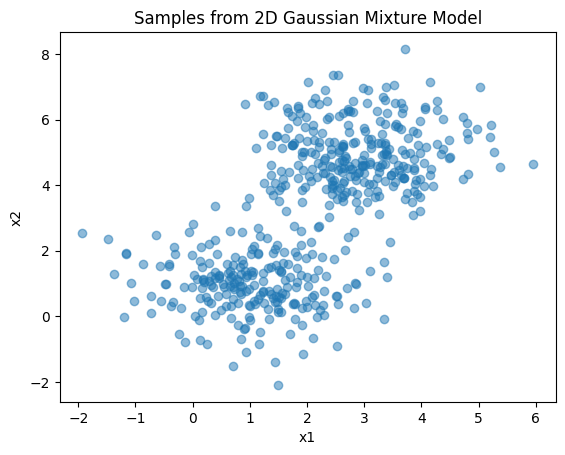

In [3]:
# Plot the samples
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.title("Samples from 2D Gaussian Mixture Model")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

## Switch to NUTS

In [4]:
seed_value = 42  # Replace with your desired seed value
torch.manual_seed(seed_value)
pyro.set_rng_seed(seed_value)
numpy.random.seed(seed_value)

# MAP or diagonal normal?
MAP=True
if MAP:
  MAXIT=2000 # SVI iterations
  REPORT=200 # Plot ELBO each time after this amount of SVI iterations
else:
  MAXIT=100000
  REPORT=1000

# Number of samples used in prediction
S=500

In [5]:
def accuracy(pred, data):
  """
  Calculate accuracy of predicted labels (integers).

  pred: predictions, tensor[sample_index, chain_index, data_index, logits]
  data: actual data (digit), tensor[data_index]

  Prediction is taken as most common predicted value.
  Returns accuracy (#correct/#total).
  """
  n=data.shape[0]
  correct=0
  total=0
  for i in range(0, n):
      # Get most common prediction value from logits
      pred_i=int(torch.argmax(torch.sum(pred[:,0,i,:],0)))
      # Compare prediction with data
      if int(data[i])==int(pred_i):
          correct+=1.0
      total+=1.0
  # Return fractional accuracy
  return correct/total

In [6]:
# Iris data set
Dx=4 # Input vector dim
Dy=3 # Number of labels

iris=sklearn.datasets.load_iris()
x_all=torch.tensor(iris.data, dtype=torch.float) # Input vector (4D)
y_all=torch.tensor(iris.target, dtype=torch.int) # Label(3 classes)

# Make training and test set
x, x_test, y, y_test = sklearn.model_selection.train_test_split(
    x_all, y_all, test_size=0.33, random_state=42)

print("Data set iris test set sizes: %i, %i." % (x.shape[0], x_test.shape[0]))

Data set iris test set sizes: 100, 50.


In [8]:
from Model import Model

ModuleNotFoundError: No module named 'Model'

### SVI

In [8]:
# Instantiate the Model object
model=Model()

if MAP:
    # MAP estimate of model parameter (here SVI boild down to simple gradient descent)
    guide=pyro.infer.autoguide.AutoDelta(model)
else:
    # Variational estimate of model parameters using diagonal normal (SVI)
    guide=pyro.infer.autoguide.AutoDiagonalNormal(model)

# Optimizer
adam=pyro.optim.Adam({"lr": 0.01})
# SVI
svi=pyro.infer.SVI(model, guide, adam, loss=pyro.infer.Trace_ELBO())

# Clear any previously used parameters
pyro.clear_param_store()

# Optimize the ELBO
elbo=[]
for j in range(0, MAXIT):
    loss=svi.step(x, y)
    elbo.append(loss)
    if j%REPORT==0:
        print("[Iteration %04d] loss: %.4f" % (j, loss))


[Iteration 0000] loss: 188.0556
[Iteration 0200] loss: 88.5219
[Iteration 0400] loss: 87.6917
[Iteration 0600] loss: 87.5640
[Iteration 0800] loss: 87.5460
[Iteration 1000] loss: 87.5454
[Iteration 1200] loss: 87.5479
[Iteration 1400] loss: 87.6527
[Iteration 1600] loss: 87.5408
[Iteration 1800] loss: 87.5406


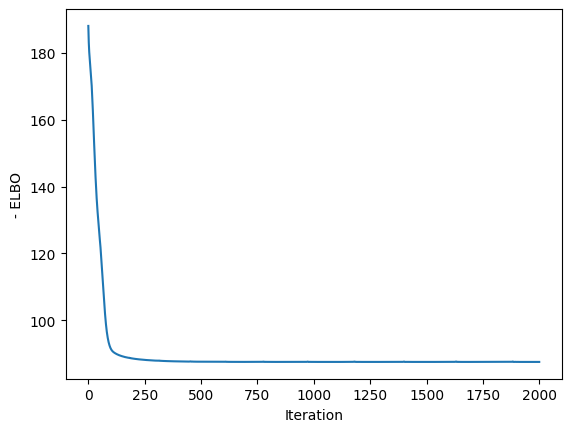

In [9]:
# ELBO vs. iteration plot
plt.xlabel("Iteration")
plt.ylabel("- ELBO")
plt.plot(elbo)

In [10]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDelta.w1 Parameter containing:
tensor([[-0.2765,  0.2770,  0.1315, -0.0905, -0.0906],
        [-0.5053,  0.5062,  0.2951, -0.3772, -0.3774],
        [ 0.5032, -0.5040, -0.3144,  0.6117,  0.6120],
        [ 0.8447, -0.8461, -0.4528,  0.2644,  0.2644]], requires_grad=True)
AutoDelta.b1 Parameter containing:
tensor([-0.6339,  0.6350,  0.2953, -0.0600, -0.0600], requires_grad=True)
AutoDelta.w2 Parameter containing:
tensor([[ 0.1395,  0.8130, -0.1391, -0.8126,  0.8132],
        [-0.1389, -0.8143,  0.1386,  0.8141, -0.8144],
        [-0.3351, -0.4399,  0.3375,  0.4389, -0.4393],
        [ 0.7146, -0.0385, -0.7144,  0.0384, -0.0385],
        [ 0.7153, -0.0386, -0.7146,  0.0385, -0.0386]], requires_grad=True)
AutoDelta.b2 Parameter containing:
tensor([ 0.1218, -0.1285, -0.1222,  0.1282, -0.1284], requires_grad=True)
AutoDelta.w3 Parameter containing:
tensor([[-1.3203,  0.9797,  0.3405],
        [-0.4262, -0.7263,  1.1524],
        [ 1.3203, -0.9798, -0.3405],
        [ 0.4264,  0.7256, -1

In [11]:
guide.requires_grad_(False)

posterior_predictive=pyro.infer.Predictive(model, guide=guide, num_samples=S, return_sites=["logits"])(
x_test, None
)

In [12]:
# Print accuracy
logits=posterior_predictive['logits']
print("Shape of posterior preditive for y (logits):", logits.shape)
print("Success: %.2f" % accuracy(logits, y_test))

Shape of posterior preditive for y (logits): torch.Size([500, 1, 50, 3])
Success: 0.98


### NUTS

In [34]:
import torch.multiprocessing as mp
import dill

In [35]:
mp.set_start_method("spawn", force=True)
mp.get_context("spawn").ForkingPickler = dill.ForkingPickler

AttributeError: module 'dill' has no attribute 'ForkingPickler'

In [24]:
# Clear any previously used parameters
pyro.clear_param_store()

In [31]:
if __name__ == "__main__":
    # Run NUTS Sampling
    print("Running NUTS Sampling...")
    nuts_kernel = pyro.infer.NUTS(model, jit_compile=True)
    mcmc = pyro.infer.MCMC(
        nuts_kernel, 
        num_samples=500,  # Number of samples to draw
        warmup_steps=400,  # Number of warm-up (burn-in) steps
        num_chains=4       # Single chain
    )
    mcmc.run(x, y)

    # Extract Posterior Samples
    posterior_samples = mcmc.get_samples()

    predictive = pyro.infer.Predictive(
        model, 
        posterior_samples=posterior_samples,  # Use samples from NUTS
        num_samples=500,                      # Number of posterior predictive samples
        return_sites=["logits"]               # Include model's logits in the output
    )
    posterior_predictive = predictive(x_test, None)

Running NUTS Sampling...


Warmup [1]:   0%|          | 0/900 [00:00, ?it/s]


Warmup [4]:   0%|          | 0/900 [00:00, ?it/s]


PicklingError: Can't pickle <class '__main__.Model'>: it's not the same object as __main__.Model

In [27]:
logits=posterior_predictive['logits']
print("Shape of posterior preditive for y (logits):", logits.shape)
print("Success: %.2f" % accuracy(logits, y_test))

Shape of posterior preditive for y (logits): torch.Size([500, 1, 50, 3])
Success: 0.98


/Users/alexandroskyriakopoulos/anaconda3/envs/py313/lib/python3.13/site-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


------------------------------Summary Statistics:-----------------------------
           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b1[0]    -0.081  1.056  -2.004    1.822      0.112    0.079      88.0   
b1[1]    -0.032  1.030  -2.066    1.679      0.104    0.074      98.0   
b1[2]    -0.113  0.975  -1.986    1.515      0.061    0.044     255.0   
b1[3]    -0.101  0.995  -1.724    1.937      0.073    0.052     193.0   
b1[4]    -0.152  1.061  -2.264    1.589      0.094    0.067     127.0   
...         ...    ...     ...      ...        ...      ...       ...   
w3[3, 1] -0.136  1.294  -2.554    2.108      0.082    0.058     258.0   
w3[3, 2]  0.088  1.357  -2.307    2.588      0.107    0.076     162.0   
w3[4, 0] -0.100  1.345  -2.734    2.176      0.087    0.061     248.0   
w3[4, 1] -0.013  1.322  -2.300    2.288      0.095    0.067     197.0   
w3[4, 2]  0.156  1.261  -2.124    2.537      0.090    0.064     196.0   

          ess_tail  r_hat  
b1[0]        234

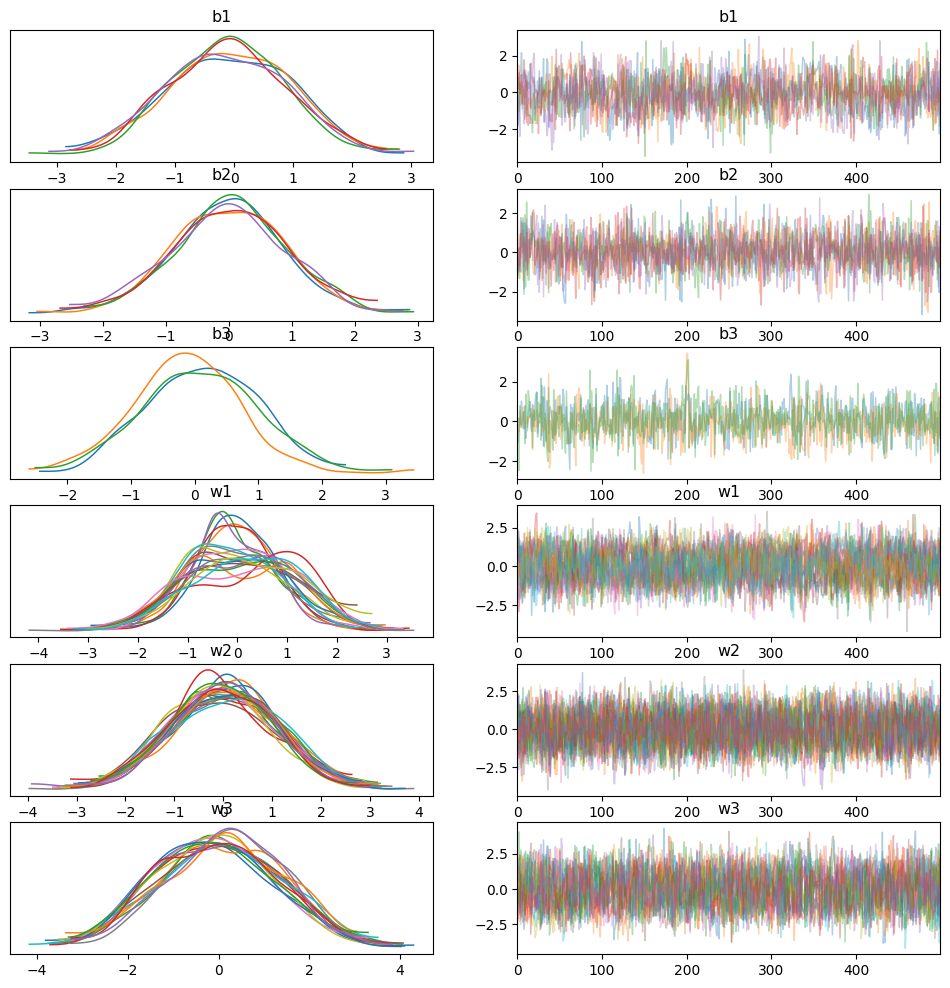

/Users/alexandroskyriakopoulos/anaconda3/envs/py313/lib/python3.13/site-packages/arviz/plots/backends/matplotlib/pairplot.py:233: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


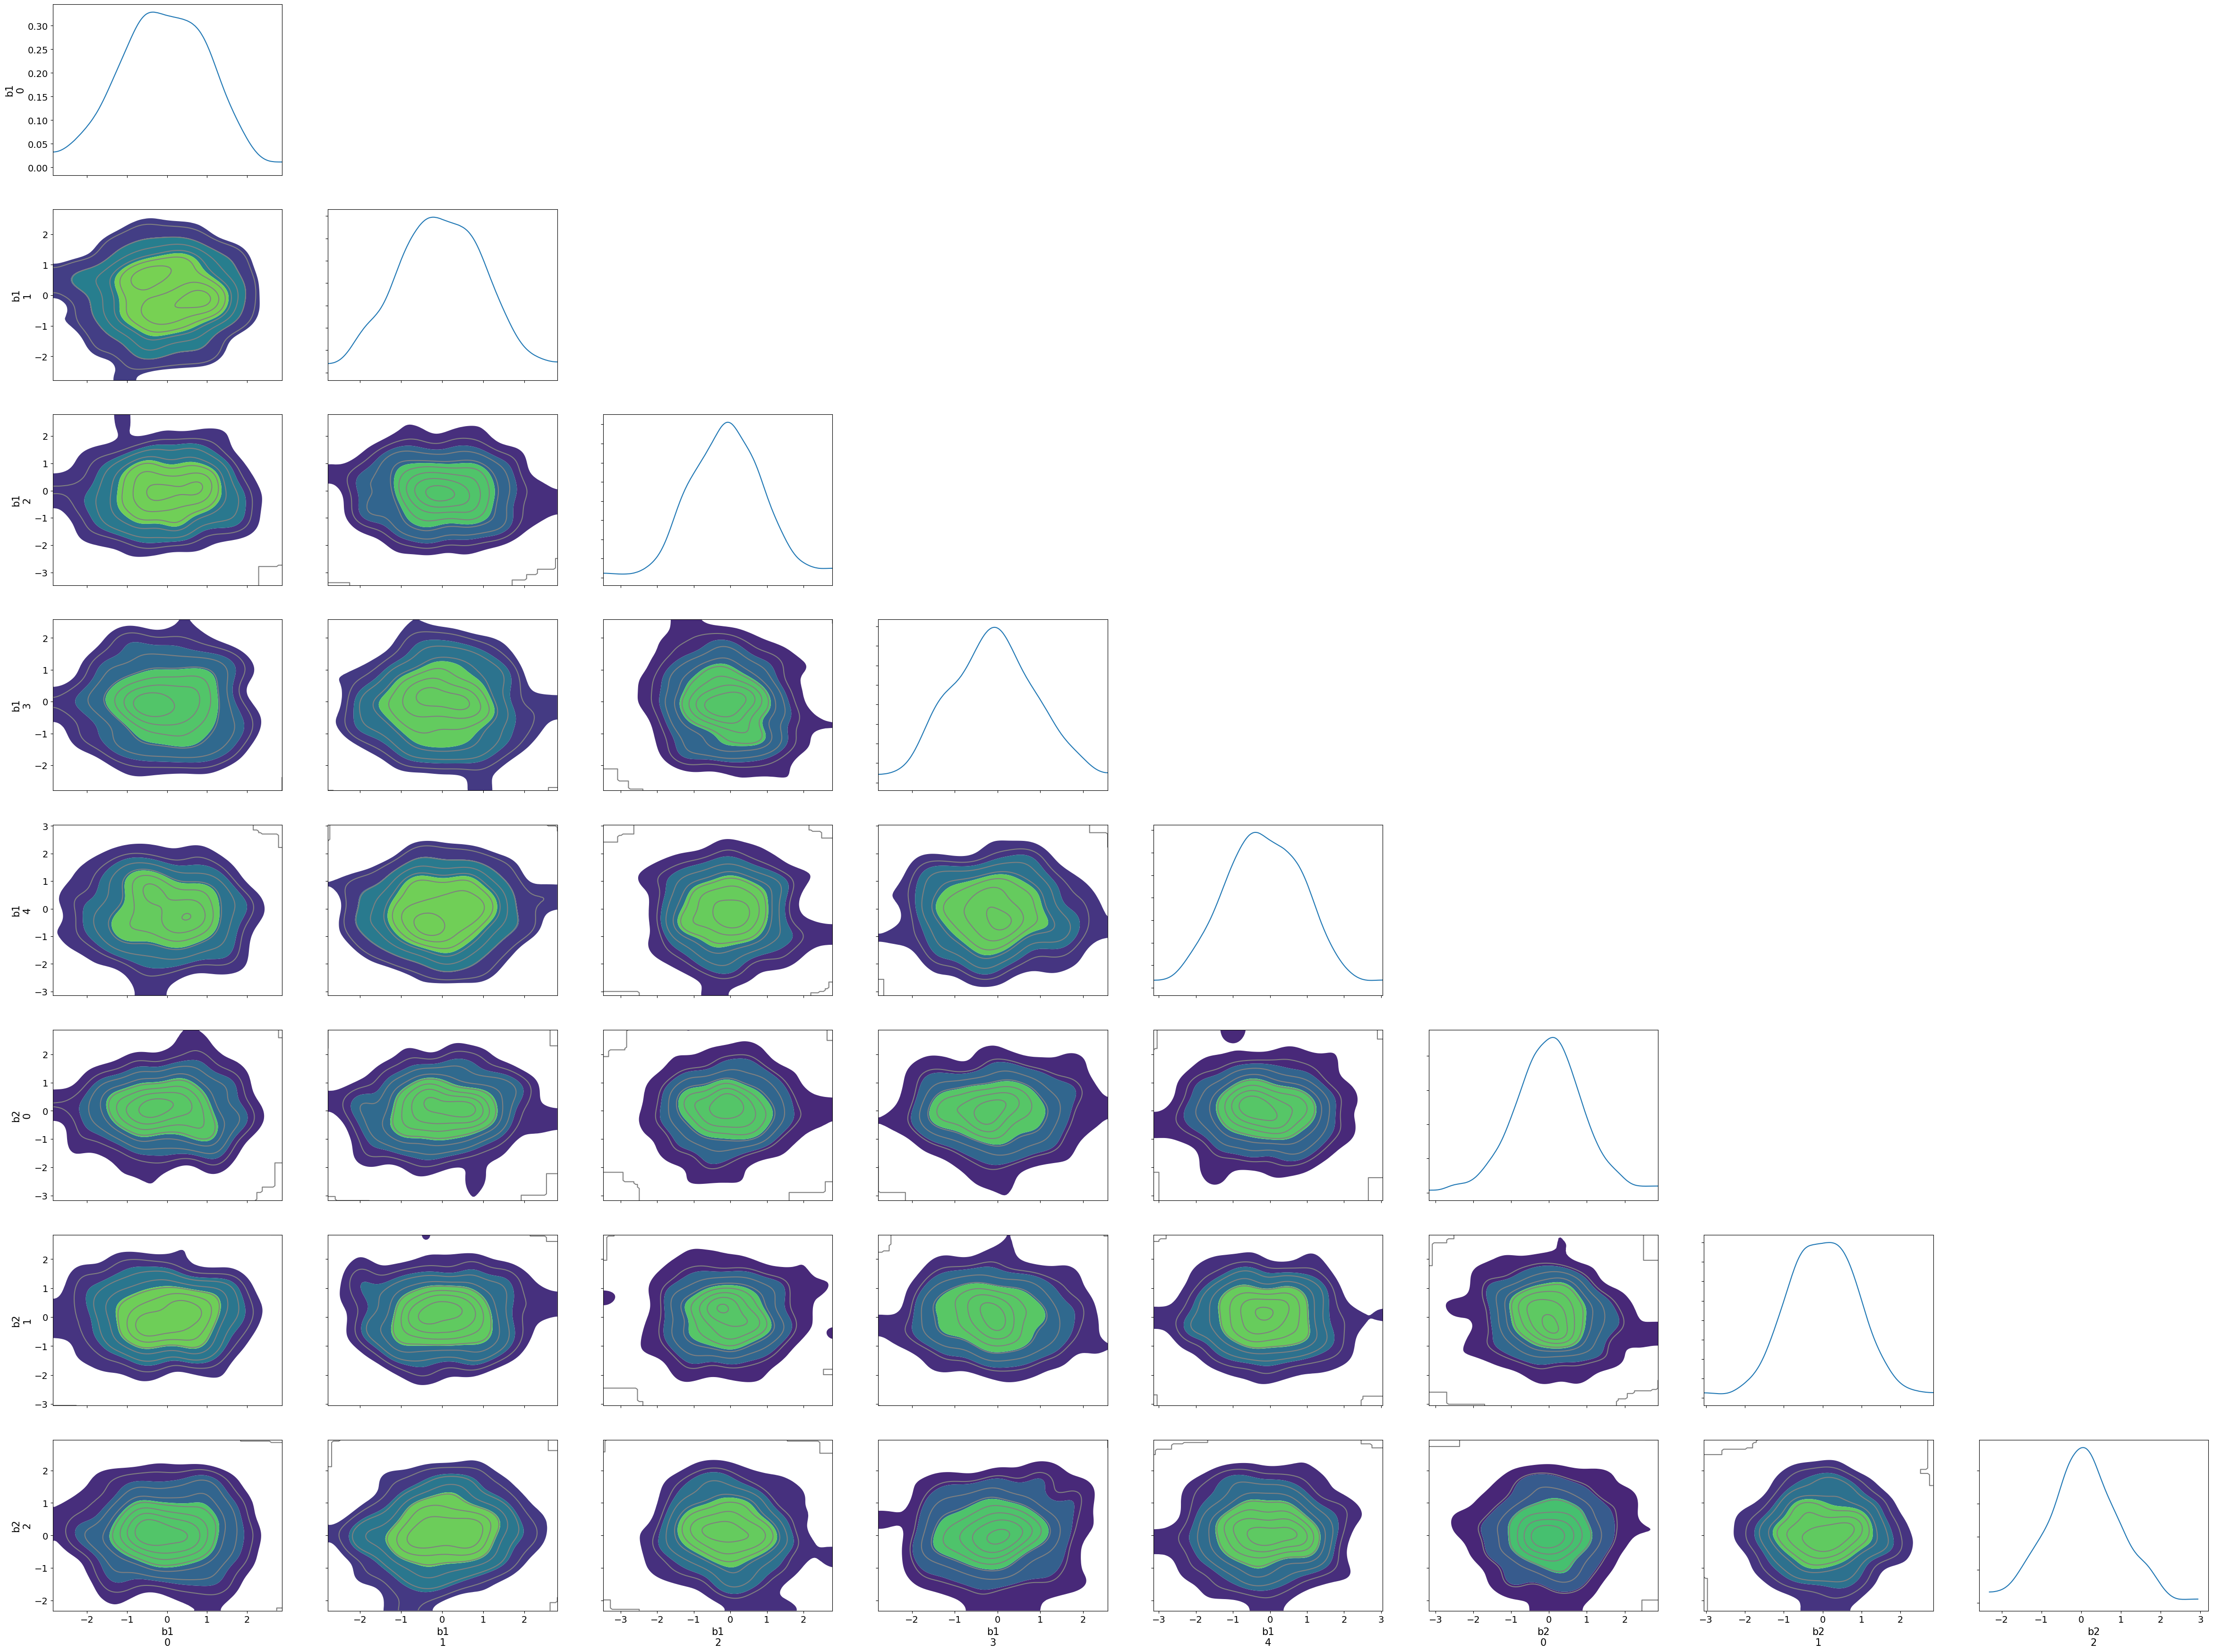

/Users/alexandroskyriakopoulos/anaconda3/envs/py313/lib/python3.13/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (73) in plot_ess, generating only 40 plots
  warnings.warn(


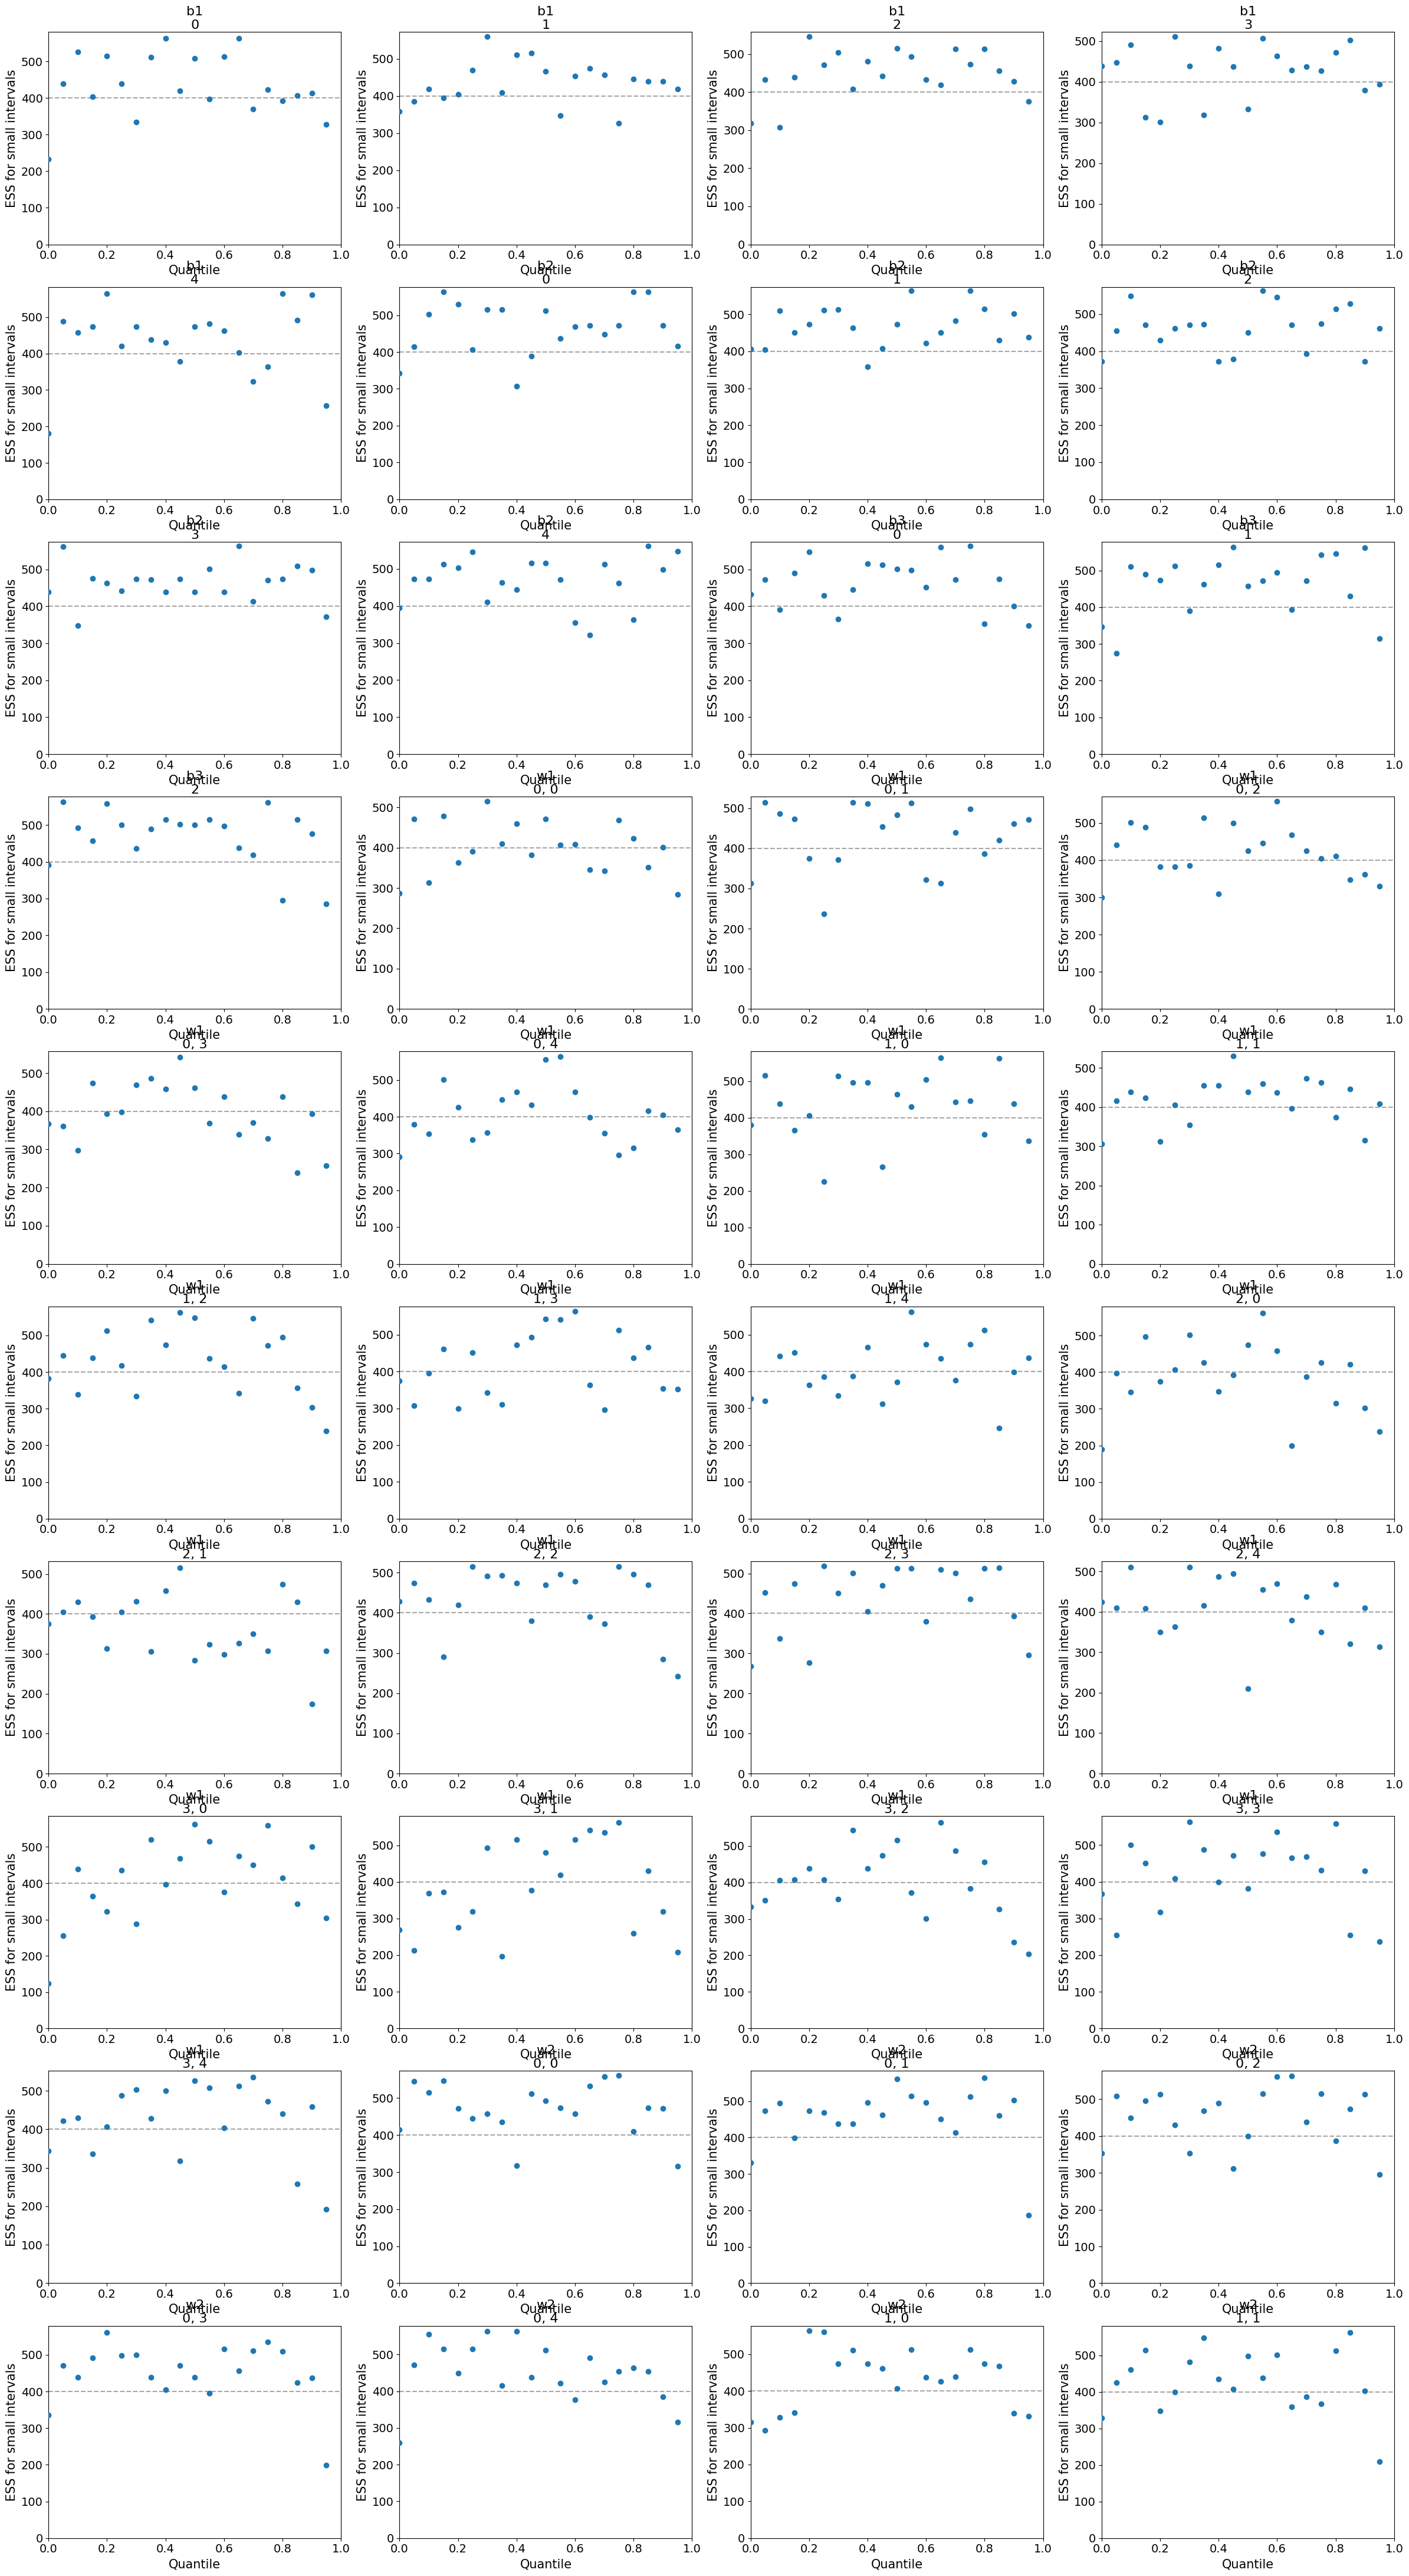

/Users/alexandroskyriakopoulos/anaconda3/envs/py313/lib/python3.13/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (73) in plot_posterior, generating only 40 plots
  warnings.warn(


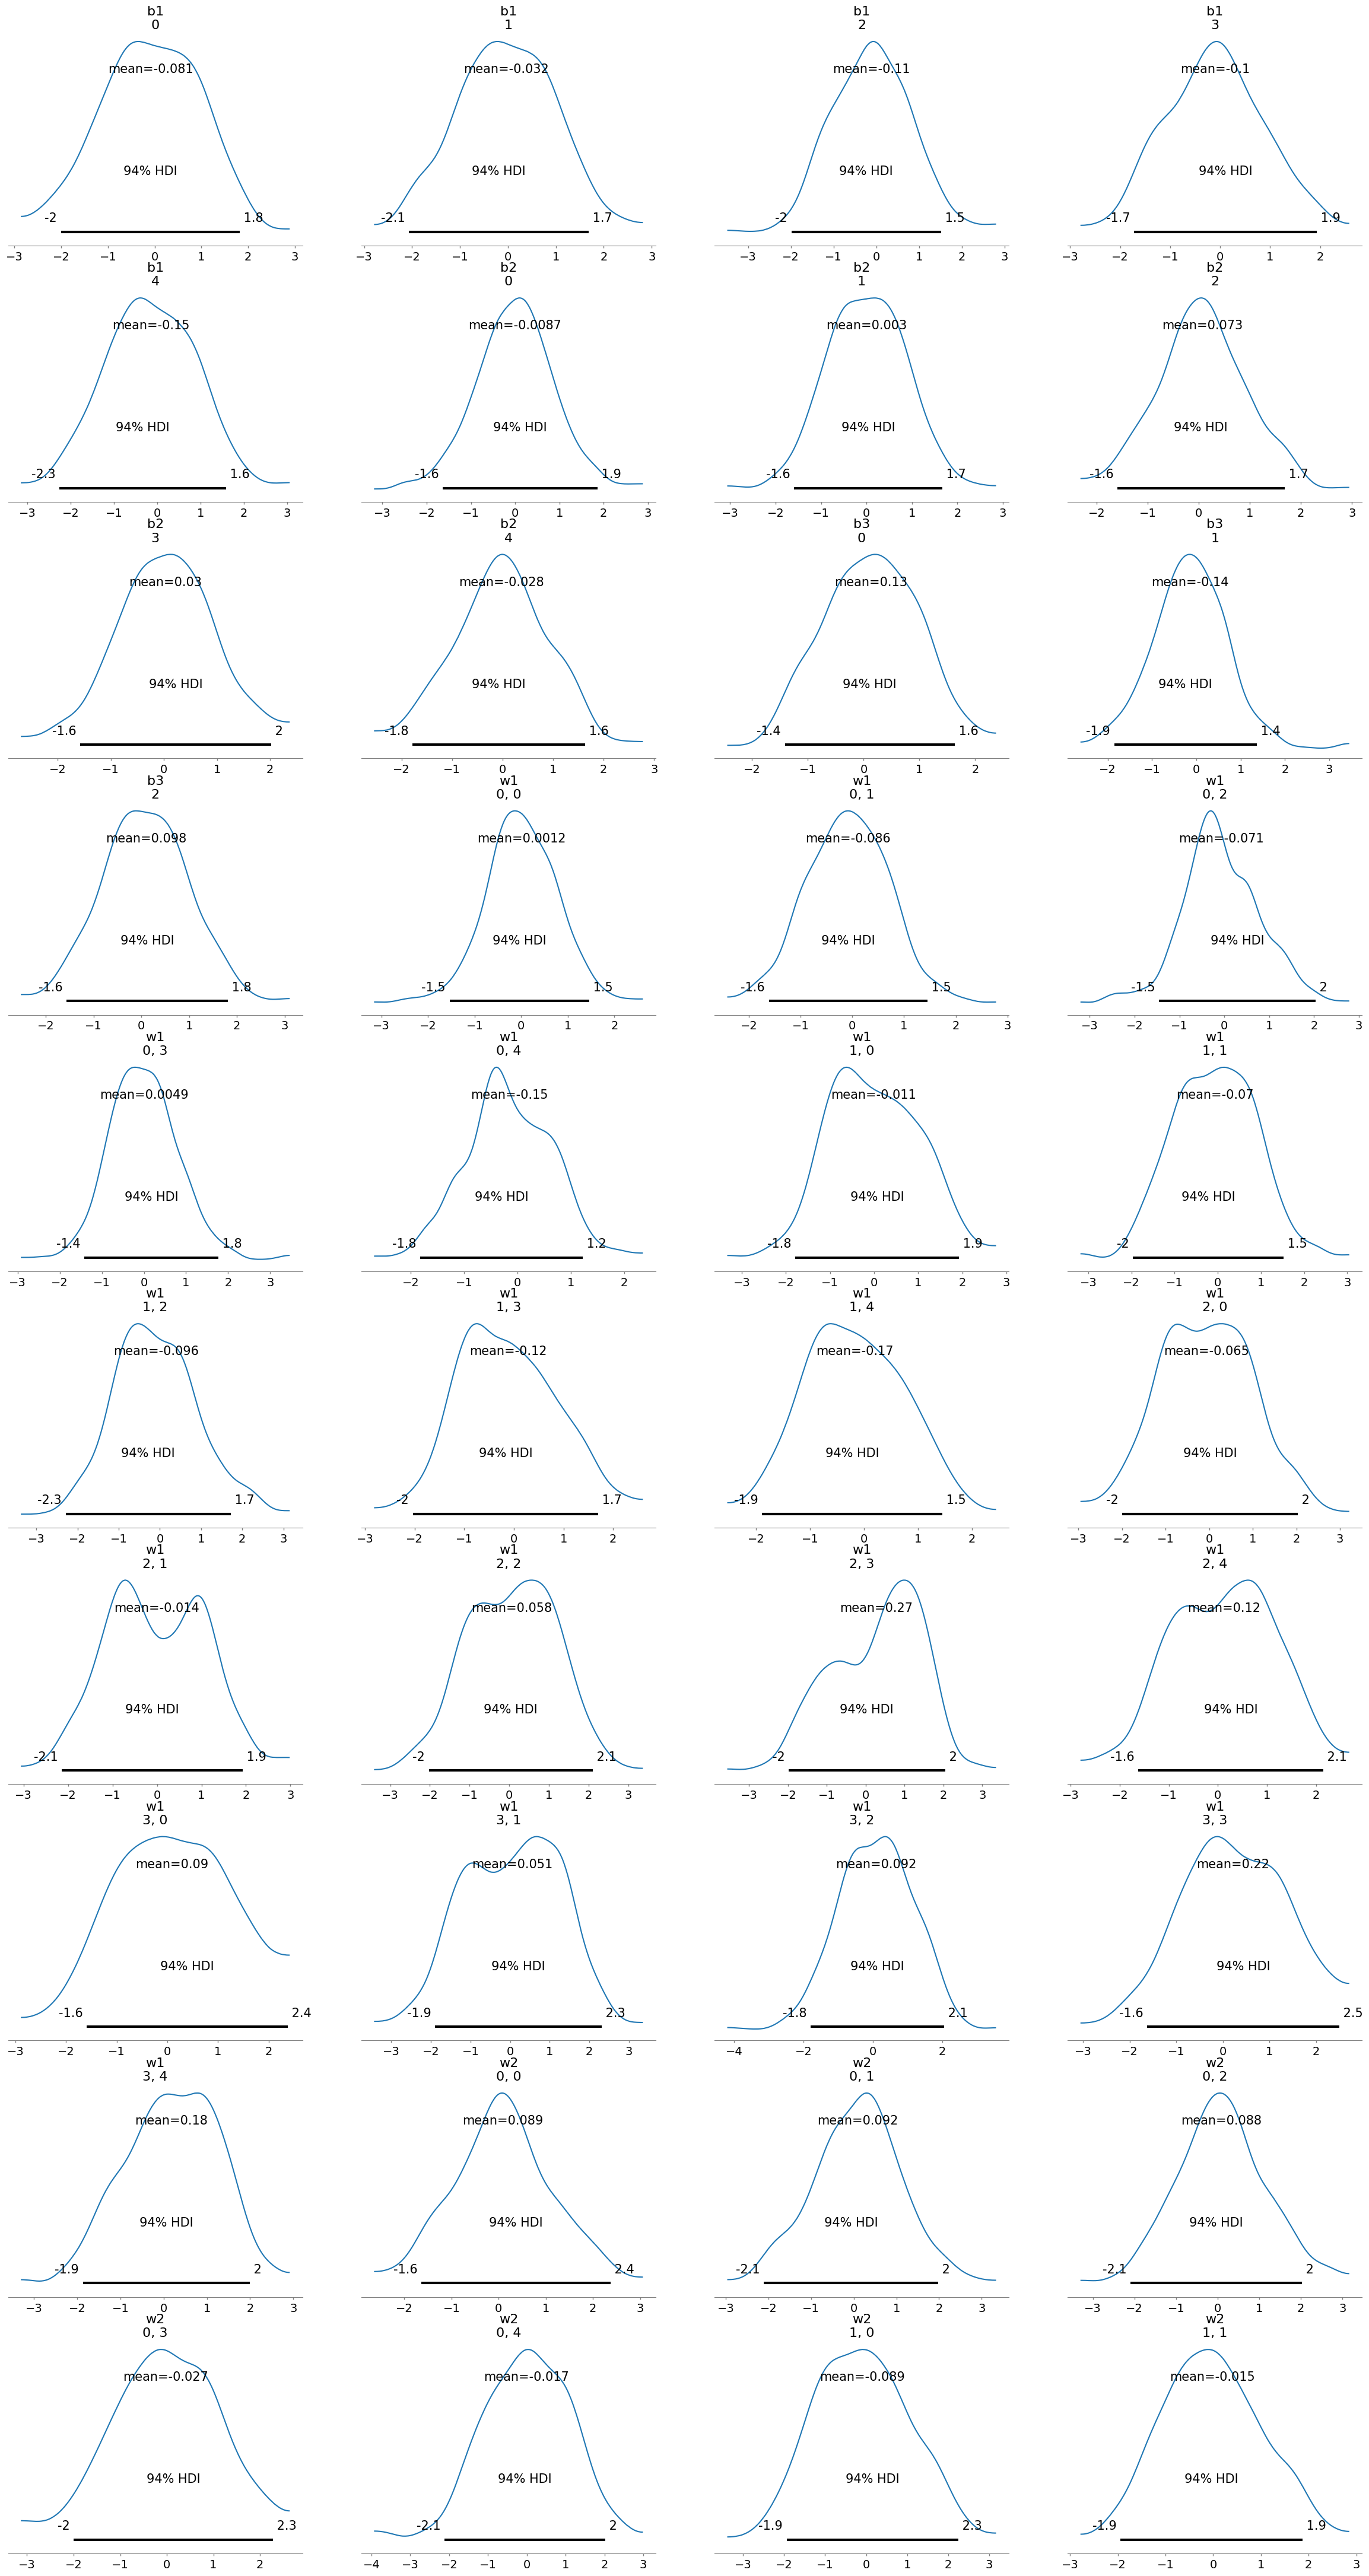

In [28]:
import arviz as az
# Convert Pyro samples to ArviZ InferenceData
idata = az.from_pyro(mcmc)

print('------------------------------Summary Statistics:-----------------------------')
summary = az.summary(idata)
print(summary)

# Trace plot to check chain mixing
az.plot_trace(idata)
plt.show()

# Pair plot to check parameter relationships
az.plot_pair(idata, kind="kde", marginals=True)
plt.show()

# Plot effective sample size (ESS)
az.plot_ess(idata)
plt.show()

az.plot_posterior(idata)
plt.show()